## 時系列データにおけるk近傍法について調査し、軽く記述

https://www.albert2005.co.jp/knowledge/machine_learning/anomaly_detection_basics/anomaly_detection_time
こちらのAlbertの記事を参考にしました。

時間依存性の高いデータに対してホテリング理論をそのまま適用すると、異常値の評価が甘くなり、異常値が検知されにくくなる.そのため,時系列データに対してkNN方が有効である.外れ値検知では「窓」と呼ばれる固定された区間を定めることでkNNを適用でき,異常部位検出においても同様の方法で適用できる.

k近傍法を用いた外れ値検知の手順

1.直前の時系列データからある一定の窓幅の部分時系列を取り出す

2.新たに得られたデータ点と部分時系列のそれぞれのデータ点までの距離を全て計算する

3.2で計算した距離のうち最も短いものをk個選び、その平均を新たに得られたデータ点の異常度とする

4.異常度がある閾値以上であれば、外れ値として検知する

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean, variance
from sklearn.neighbors import NearestNeighbors

#data = pd.read_csv("D:sprint35/btc.csv", encoding="shift-jis", header=None)
data = pd.read_csv("btc.csv", encoding="shift-jis", header=None)


In [3]:
# 四本値とは、ある一定期間の始値、終値、高値、安値の4つの価格
data

,0,1,2,3,4,5
0,2016-12-30 00:00:00,0.00769,0.00875,0.00769,0.00845,7870.4500
1,2016-12-31 00:00:00,0.00850,0.00891,0.00842,0.00843,3269.1045
2,2017-01-01 00:00:00,0.00856,0.00864,0.00826,0.00833,3206.9350
3,2017-01-02 00:00:00,0.00838,0.00892,0.00811,0.00821,5814.5170
4,2017-01-03 00:00:00,0.00821,0.00854,0.00800,0.00850,690.7145
5,2017-01-04 00:00:00,0.00822,0.00975,0.00812,0.00936,20604.2420
6,2017-01-05 00:00:00,0.00935,0.01133,0.00930,0.00973,18242.3070
7,2017-01-06 00:00:00,0.00973,0.01050,0.00915,0.01021,15751.7520
8,2017-01-07 00:00:00,0.01021,0.01156,0.01005,0.01131,14538.9420
9,2017-01-08 00:00:00,0.01127,0.01190,0.01049,0.01065,7393.4067


In [4]:
# x 年月日時刻
x = data.iloc[:,0:1].values
x = x.reshape(-1)

In [5]:
# y 時系列順の始値
y = data.iloc[:,1:2].values
y = y.reshape(-1)

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


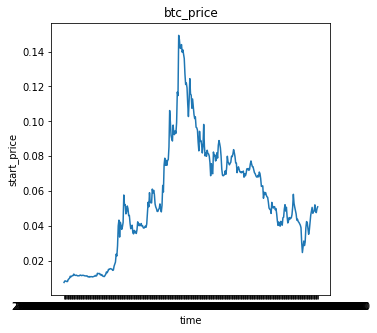

In [6]:
# 始まり値の変動の可視化
plt.figure(figsize=(5,5))
plt.title('btc_price')
plt.xlabel('time')
plt.ylabel('start_price')
plt.plot(x,y)

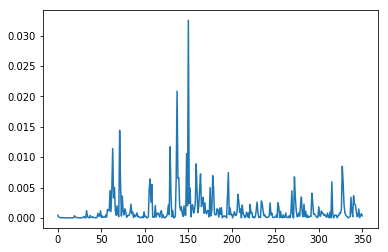

In [7]:
def knn(data,wide, k):
    """
    data: 時系列順に並ぶデータ
    wide毎にdataをとってきてwide内のすべての点と次のデータ点との距離を全て算出
    距離が短い順にk個選び,平均を算出する.
    """
    anormaly_score = []
    # 繰り返す回数はdataの長さ-wide+1
    data_length = len(data)
    iter_num = data_length - wide + 1
    # sliding_window
    for i in range(iter_num-1):
        w1 = data[i:i+wide]
        w2 = data[i+wide]
        #1次元なのでabs
        if w1.ndim == 1:
            distance = abs(w1-w2)
            #print('distance',distance)
        else:
            distance = np.linalg.norm(w1,w2)
        sort_distance = np.sort(distance)
        k_dis_mean = np.mean(sort_distance[:k])
        anormaly_score += [k_dis_mean]
        
    return anormaly_score

# yは時系列順に並ぶ始値のデータ
anormaly_score = knn(y,15,1)
plt.plot(anormaly_score)

In [43]:
# 標本平均を計算 始まり値のデータy
mean_y = mean(y)

In [44]:
# 標本分散を計算
val_y = variance(y)

$$
\sum_{i=1}^{M}{(\frac{x_i-\mu_i}{\sigma_i})}^2
$$

In [45]:
# 異常度を計算 M =1, μ=mean_anormaly_score, σ = √val_anormaly_score
scores = (y-mean_y)**2 / val_y

In [46]:
# カイ二乗分布による1%水準の閾値
from scipy import stats
threshold = stats.chi2.interval(0.99, 1)[1]
threshold

7.879438576622417

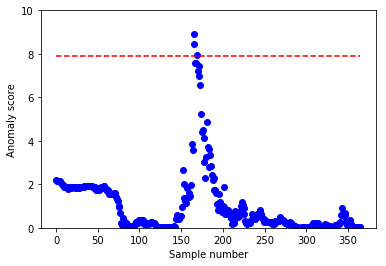

In [47]:
# 結果の描画
plt.plot(scores, "o", color = "b")
plt.plot([0,365],[threshold, threshold], 'k-', color = "r", ls = "dashed")
plt.xlabel("Sample number")
plt.ylabel("Anomaly score")
plt.ylim([0,10])
plt.show()

In [52]:
score_list = scores.tolist()

In [89]:
# 異常日を格納するリストの作成
over  = filter(lambda x: x > threshold, score_list)
over_list = list(over)
x_list = [score_list.index(i) for i in over_list ]
x_list

[165, 166, 169]

In [90]:
a = x[165].split('-')
print(a[0])
print(a[1])
print(a[2])

2017
06
14 00:00:00


In [94]:
#データの何日目が異常と見なされるか
import datetime
# 初日x[0]
before = x[0].split('-')
year = int(before[0])
month = int(before[1])
date = int(before[2][:2])
before = datetime.date(year, month, date)
# 異常値であった日は何日目か
for i in x_list:
    after = x[i].split('-')
    year = int(after[0])
    month = int(after[1])
    date = int(after[2][:2])
    after = datetime.date(year, month, date)
    days = ((after-before).days)
    print('{}日目'.format(days+1))

167日目
168日目
171日目
